In [1]:
import syft as sy
from utils import *

/home/e/anaconda3/envs/Hagrid/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TissueMNIST-e6916fbe07ec4302be04779d346e8a94.pkl is already downloaded
Columns: Index(['patient_ids', 'images', 'labels'], dtype='object')
Total Images: 2363
Label Mapping {'Collecting Duct, Connecting Tubule': 0, 'Distal Convoluted Tubule': 1, 'Glomerular endothelial cells': 2, 'Interstitial endothelial cells': 3, 'Leukocytes': 4, 'Podocytes': 5, 'Proximal Tubule Segments': 6, 'Thick Ascending Limb': 7}


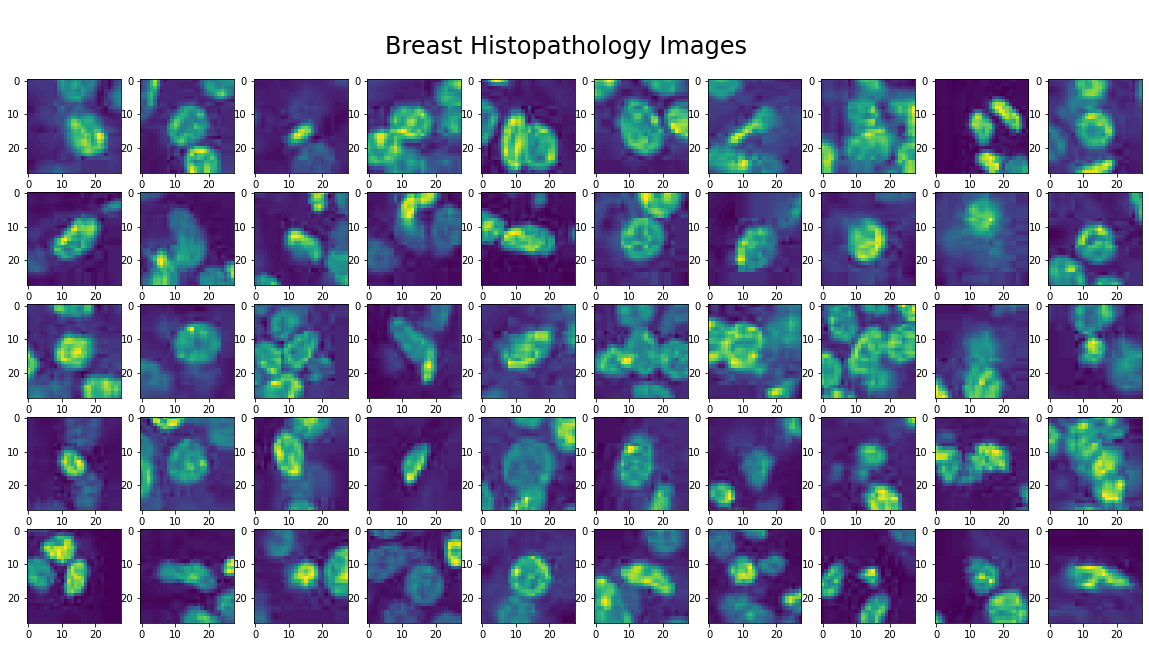

In [2]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/TissueMNIST/subsets/TissueMNIST-e6916fbe07ec4302be04779d346e8a94.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [3]:
dataset.head()

,patient_ids,images,labels
0,55614,"[[18, 24, 65, 110, 113, 90, 74, 68, 43, 29, 14...",4
1,55614,"[[5, 6, 9, 12, 10, 9, 15, 24, 33, 28, 28, 31, ...",1
2,55614,"[[15, 11, 10, 11, 10, 6, 6, 9, 9, 11, 12, 12, ...",5
3,55614,"[[6, 5, 5, 5, 5, 5, 4, 4, 8, 7, 6, 5, 5, 6, 6,...",7
4,55614,"[[31, 14, 13, 18, 11, 7, 13, 18, 11, 11, 12, 1...",0


In [4]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (1897, 3, 50, 50)
Dims (243, 3, 50, 50)
Dims (223, 3, 50, 50)
Preprocessing completed.


In [5]:
# run this cell
data_subjects = DataSubjectList.from_series(train["patient_ids"])
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [6]:
data_subjects.one_hot_lookup

array(['55614', '57023', '57552', '57698', '58420', '60182', '61145',
       '63972', '66314', '67212', '67278'], dtype='<U21')

In [7]:
from syft import PhiTensor
def correct_dsl(input_tensor: PhiTensor):
    """ Corrects for the new DSL shape requirements 
    e.g. (1915,) -> (1915, 3, 50, 50) 
    """
    output_dsi = np.ones((input_tensor.shape[0], *input_tensor.shape[1:]))
    print(output_dsi.shape)
    
    for index, val in enumerate(input_tensor.data_subjects.data_subjects_indexed[0]):
        output_dsi[index] *= val
    
    input_tensor.data_subjects.data_subjects_indexed = output_dsi
    # print(output_dsi.shape)
    # print(output_dsi[0])
    # output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
    # for i in range(input_tensor.shape[0]):
    #      output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
    # input_tensor.data_subjects.data_subjects_indexed = output_dsi

correct_dsl(train_image_data.child)  
# .shape, train_image_data.child.data_subjects.shape

(1897, 3, 50, 50)


In [8]:
# data_subjects = DataSubjectList.from_series(val["patient_ids"])
# val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

In [9]:
# data_subjects = DataSubjectList.from_series(test["patient_ids"])
# test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

### Model Training

In [10]:
from syft import nn

In [11]:
input_shape = train_image_data.public_shape
input_shape

(1897, 3, 50, 50)

In [12]:
y_train = train_label_data

In [13]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 2
model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 3
# model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 4
# model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 5
# model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 6
# model.add(nn.AvgPool(7))

# # Layer 7
model.add(nn.Flatten())

# Layer 8
model.add(nn.Linear(2))

In [14]:
model.compile()

In [15]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((1897, 3, 50, 50), (1897, 3, 50, 50))

In [16]:
# for i in train_image_data.child.data_subjects.data_subjects_indexed.flatten():
#     print(i)
#     break


(1, 1881) * ones((1881, 3, 50, 50))

In [17]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((1897, 3, 50, 50), (1897, 3, 50, 50))

In [18]:
out = train_image_data[:2].child

In [19]:
train_image_data[100].child.data_subjects.one_hot_lookup

array(['55614', '57023', '57552', '57698', '58420', '60182', '61145',
       '63972', '66314', '67212', '67278'], dtype='<U21')

In [20]:
train_image_data[1500].child.data_subjects.one_hot_lookup

array(['55614', '57023', '57552', '57698', '58420', '60182', '61145',
       '63972', '66314', '67212', '67278'], dtype='<U21')

In [21]:
train_image_data[-1].child.data_subjects.one_hot_lookup

array(['55614', '57023', '57552', '57698', '58420', '60182', '61145',
       '63972', '66314', '67212', '67278'], dtype='<U21')

In [22]:
out.shape, out.data_subjects.shape

((2, 3, 50, 50), (2, 3, 50, 50))

In [23]:
for layer in model.layers:
    print("Layer Name: ", layer)
    out = layer.forward(out)
    print()

Layer Name:  Convolution
Input into Conv forward: (2, 3, 50, 50) (2, 3, 50, 50)
shapes before padding:,  (2, 3, 50, 50) (2, 3, 50, 50)
dsi_shape, width, mode (2, 3, 50, 50) ((0, 0), (0, 0), (2, 2), (2, 2)) reflect
X_col after im2col (27, 5408) (27, 5408)
out after matmul (5408, 32) (5408, 32)
out after reshape (32, 52, 52, 2) (32, 52, 52, 2)
out after transpose (2, 32, 52, 52) (2, 32, 52, 52)
out after matmul (2, 32, 52, 52) (2, 32, 52, 52)
Done with convolution

Layer Name:  BatchNorm
input shapes (2, 32, 52, 52) (2, 32, 52, 52)
PT mean gives shape of (2, 52, 52)
[2, 1, 52, 52]
mean shapes after expand (2, 1, 52, 52) (2, 1, 52, 52)
xmu shapes (2, 32, 52, 52) (2, 32, 52, 52)
xmu ohl ['55614' '57023' '57552' '57698' '58420' '60182' '61145' '63972' '66314'
 '67212' '67278']
[2, 1, 52, 52]
var shapes (2, 1, 52, 52) (2, 1, 52, 52)
sqrtvar shapes (2, 1, 52, 52) (2, 1, 52, 52)
ivar shapes (2, 1, 52, 52) (2, 1, 52, 52)
xhat shapes (2, 32, 52, 52) (1, 2, 32, 52, 52)
gamma shapes (2, 32, 52, 52

CAN YOU HEAR ME
reshaping to: (2, 1, 28, 28)
og shape (1729, 2, 28, 28)
target shape [1729, 2, 1, 28, 28]
var shapes (2, 1, 28, 28) (1729, 2, 1, 28, 28)
sqrtvar shapes (2, 1, 28, 28) (1729, 2, 1, 28, 28)
ivar shapes (2, 1, 28, 28) (1729, 2, 1, 28, 28)
xhat shapes (2, 64, 28, 28) (2017, 2, 64, 28, 28)
gamma shapes (2, 64, 28, 28) (2017, 2, 64, 28, 28)
out shapes (2, 64, 28, 28) (2017, 2, 64, 28, 28)
activated out shapes (2, 64, 28, 28) (2017, 2, 64, 28, 28)

Layer Name:  MaxPool
shapes before padding:,  (128, 1, 28, 28) (2017, 128, 1, 28, 28)
dsi_shape, width, mode (2017, 128, 1, 28, 28) ((0, 0), (0, 0), (0, 0), (0, 0)) reflect
FInished im2col, starting _argmax
outputs, DSL shape: (25088,) (2017, 25088)
reshaped outputs, DSL shape: (14, 14, 2, 64) (2017, 14, 14, 2, 64)
transposed outputs, DSL shape: (2, 64, 14, 14) (2017, 2, 64, 14, 14)
Done with MaxPool forward pass

Layer Name:  Flatten

Layer Name:  Linear



### Loss calculation

In [31]:
out.child.shape

(2, 2)

In [32]:
out.child

DeviceArray([[ 2.35585594,  0.6095969 ],
             [ 3.06935718, -2.499606  ]], dtype=float64)

In [33]:
y_true = train_label_data[:2].child

In [34]:
y_true.shape

(2,)

In [36]:
y_true

PhiTensor(child=[1 5], min_vals=<lazyrepeatarray data: 1 -> shape: (2,)>, max_vals=<lazyrepeatarray data: 5 -> shape: (2,)>)

In [37]:
train_label_data.child[:10]

PhiTensor(child=[1 5 7 4 1 3 0 0 6 6], min_vals=<lazyrepeatarray data: [1 5 7 4 1 3 0 0 6 6] -> shape: (10,)>, max_vals=<lazyrepeatarray data: [1 5 7 4 1 3 0 0 6 6] -> shape: (10,)>)

In [35]:
next_grad = model.loss.backward(out, y_true)

UnboundLocalError: local variable 'dsl1' referenced before assignment

In [ ]:
y_true = train_label_data[:2].child

In [ ]:
y_true.child

In [ ]:
out.child.shape

In [ ]:
next_grad = model.loss.backward(out, y_true)

In [ ]:
for layer in model.layers[::-1]:
    print(layer)
    next_grad = layer.backward(next_grad)

In [ ]:
model.fit(train_image_data.child, train_label_data.child, shuffle=False, max_iter=1)